# Detection and Quantification in Quantitative field imaging

In this notebook we will investigate how to detect and quantify particles in the quantitative field regime. 

The notebook contains the following sections:




## 1. Imports

In [132]:
import sys
sys.path.insert(0, "../") # Adds the module to path
import deeptrack as dt

In [133]:
import deeplay as dl

In [134]:
import help_files as hp #Helper functions for the notebook.

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [136]:
DEV = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running code on device: ({DEV}) when possible")

Running code on device: (cuda) when possible


## 2. Detection in Quantitative field imaging

Let's start by loading in data in the quantitiative field regime.

In [137]:
data = np.load("../data/qf/qf_data.npy") #Quantitative field
labels = np.load("../data/qf/qf_labels.npy") #Labels for the particles
centroids = labels[:, 0:2] #Centroids of the particles

In [138]:
#Subtracting mean in the real part so that the data is centered
data[...,0] = data[...,0] - 1

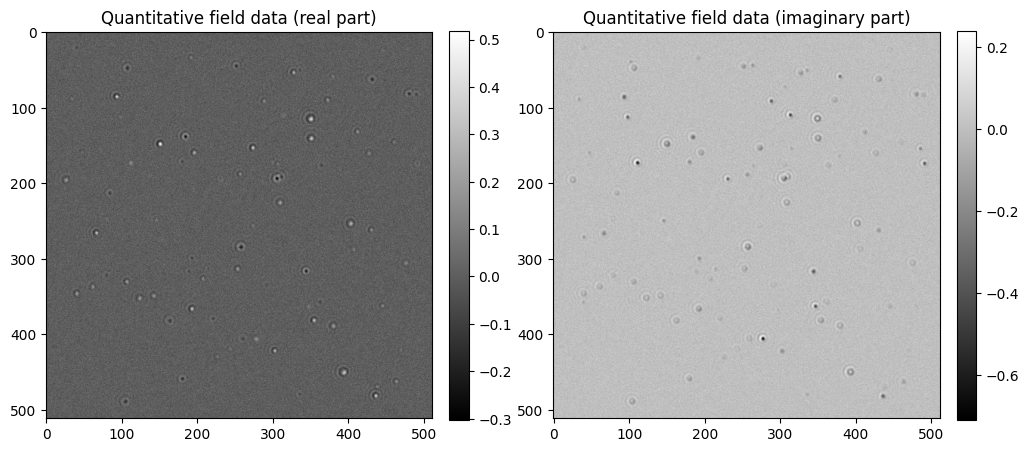

In [201]:
plt.figure(figsize=(12,6))
plt.subplot(121)
im = plt.imshow(data[...,0], cmap="gray")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Quantitative field data (real part)")
plt.subplot(122)
im = plt.imshow(data[...,1], cmap="gray")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Quantitative field data (imaginary part)")
plt.show()

### 2.1 Detecting particles using a classical method


#### 2.1.1 - Radial Variance Transform
xxx

We construct a pipeline for the Radial Variance Transform(RVT) which also incorporates a local maxima step to detect the centroids of the particles.

#### 2.1.2 - Visualizing the detections from RVT
xxx

In [140]:
###Settings for Radial Variance Transform pipeline
rmin, rmax = 3, 30
th_scale = 1.2
min_distance = 9

In [141]:
detections_rvt = hp.rvt_pipeline(data, rmin = rmin, rmax = rmax, th_scale = th_scale, min_distance = min_distance)

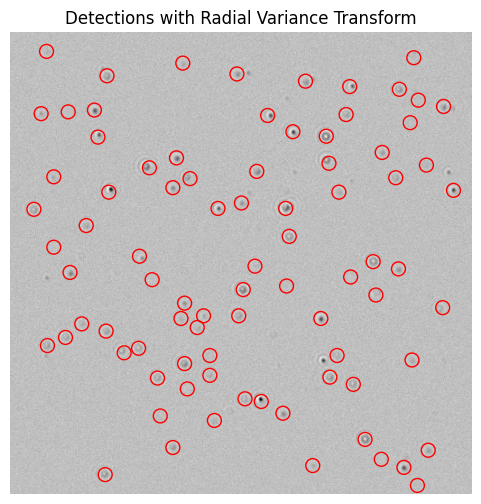

In [142]:
hp.plot_frame_with_detections(
    data = data[...,1],
    positions = detections_rvt,
    title = "Detections with Radial Variance Transform"
    )

In [143]:
radius = 6 # Radius of the particle in pixels
centroids = labels[:, :2] # We use the labels as the ground truth
mask = np.zeros_like(data[...,1])

In [144]:
GT_particles = hp.add_bin_circles(centroids, radius, mask)

Text(0.5, 1.0, 'Ground truth particles')

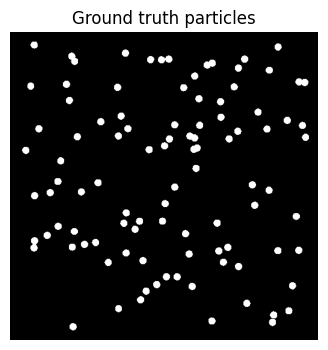

In [145]:
plt.figure(figsize=(4, 4))
plt.imshow(GT_particles, cmap="gray")
plt.axis("off")
plt.title("Ground truth particles")

In [146]:
F1_score_rvt = hp.get_F1_score(
    hp.add_bin_circles(detections_rvt, radius, mask)
    , GT_particles)
print(f"F1 score for RVT: {round(F1_score_rvt, 3)*100}%")

F1 score for RVT: 69.39999999999999%


### 2.2 Detecting particles using LodeSTAR model

xxx

#### 2.2.1  Prepare the Training Crop
We will use a single crop of a single particle to train the neural network.

In [147]:
crop_size = 40
labels_idx = 11

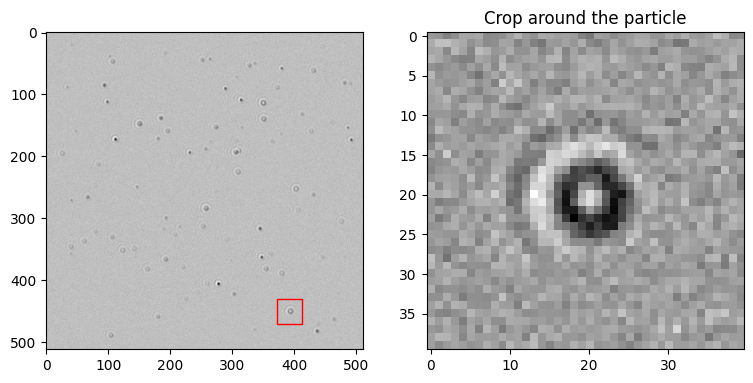

In [148]:
import matplotlib.patches as patches

# We crop the image around the particle (based on the labels) - One could also use the detections or manually select a particle.
crop_x0 = int(labels[labels_idx, 0] - crop_size/2)
crop_y0 = int(labels[labels_idx, 1] - crop_size/2)

crop = data[crop_x0:crop_x0 + crop_size, crop_y0:crop_y0 + crop_size, :]

plt.figure(figsize=(9, 6))

plt.subplot(1, 2, 1)
plt.imshow(data[...,1], cmap="gray")
plt.gca().add_patch(patches.Rectangle((crop_y0, crop_x0), crop_size, crop_size,
                                      linewidth=1, edgecolor="r",
                                      facecolor="none"))

plt.subplot(1, 2, 2)
plt.title("Crop around the particle")
plt.imshow(crop[...,1], cmap="gray")

plt.show()

(-0.5, 39.5, 39.5, -0.5)

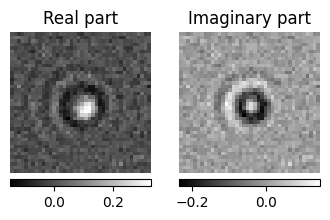

In [149]:
plt.figure(figsize=(4,2))
plt.subplot(1,2,1)
plt.title("Real part", fontsize = 12)
im = plt.imshow(crop[...,0], cmap="gray")
plt.colorbar(im, fraction=0.046, pad=0.04, orientation = "horizontal")
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Imaginary part", fontsize = 12)
im = plt.imshow(crop[...,1], cmap = 'gray')
plt.colorbar(im, fraction=0.046, pad=0.04, orientation = "horizontal")
plt.axis('off')

#### 2.2.2  Prepare pipeline and train model
We will create a pipeline for training the LodeSTAR model

In [150]:
x,y=np.meshgrid(
    np.arange(crop_size)-crop_size,
    np.arange(crop_size)-crop_size
    )

def grad(dx1,dx2,dy1,dy2):
    def inner(image):
        image[...,0]+=dx1*x+dy1*y
        image[...,1]+=dx2*x+dy2*y
        return image
    return inner

addgrad=dt.Lambda(
    grad,
    dx1=lambda: .02/40*np.random.randn(),
    dx2=lambda: .02/40*np.random.randn(),
    dy1=lambda: .02/40*np.random.randn(),
    dy2=lambda: .02/40*np.random.randn()
    )

In [151]:
IMAGE_SIZE = 40
PADDING = 64
WAVELENGTH = 532e-9
RESOLUTION = 1.14e-7

#For z-propagation
crop_propagation_forward = dt.get_propagation_matrix((IMAGE_SIZE + PADDING, ) * 2, 1e-7, RESOLUTION, WAVELENGTH)
crop_propagation_backward = dt.get_propagation_matrix((IMAGE_SIZE + PADDING, ) * 2, -1e-7, RESOLUTION, WAVELENGTH)

#Training pipeline
training_pipeline = (
    dt.Value(crop)
    >> dt.FourierTransform() 
    >> dt.FourierTransformTransformation(crop_propagation_forward, crop_propagation_backward, lambda:np.random.uniform(-10, 10)) 
    >> dt.InverseFourierTransform() 
    >> dt.Multiply(lambda: np.random.uniform(0.1, 3))
    >> dt.Add(lambda: np.random.uniform(-0.1, 0.1))
    >> addgrad
    >> dt.Gaussian(sigma=lambda: np.random.rand() * 1e-3)
    >> dt.MoveAxis(-1, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)

#Training dataset
training_dataset = dt.pytorch.Dataset(training_pipeline, length=2000, replace=False)

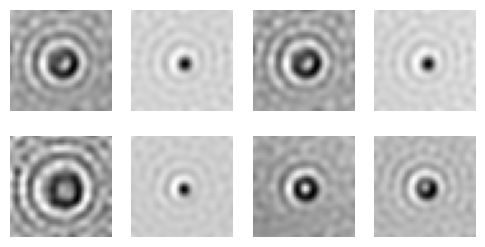

In [152]:
dataloader = dl.DataLoader(training_dataset, batch_size=8, shuffle=True)

batch = next(iter(dataloader))
#Visualize a batch
plt.figure(figsize=(6, 3))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(batch[0][i,1], cmap="gray")
    plt.axis("off")

In [153]:
lodestar = dl.LodeSTAR(n_transforms=4, optimizer=dl.Adam(lr=2e-4)).build().to(DEV)

In [154]:
TRAIN_MODEL = False

if TRAIN_MODEL:
    #Train model for max_epochs.
    trainer = dl.Trainer(max_epochs=100)
    trainer.fit(lodestar, dataloader)
else:
    lodestar.load_state_dict(torch.load("../models/brightfield/lodestar_tracking.pth"))
    lodestar.eval()
lodestar = lodestar.to(DEV)

#### 2.2.3  Visualize result from trained LodeSTAR model

xxx

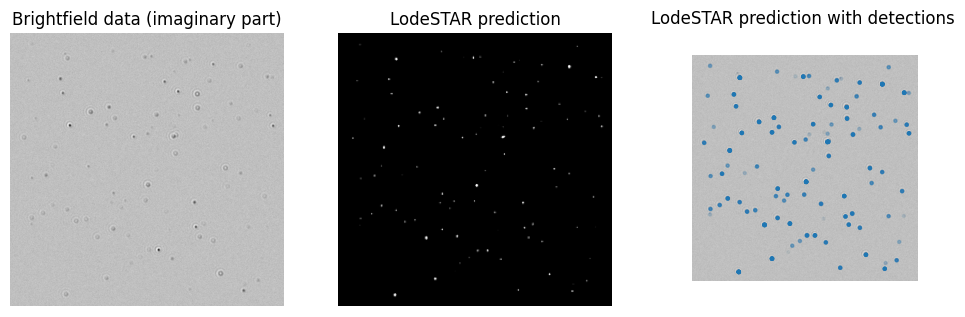

In [155]:
torch_image = torch.from_numpy(data).permute(2, 0, 1).unsqueeze(0).float().to(DEV)
prediction = lodestar(torch_image)[0].cpu().detach().numpy()
x, y, rho = prediction[0], prediction[1], prediction[-1]

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Brightfield data (imaginary part)")
plt.imshow(data[...,1], cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("LodeSTAR prediction")
plt.imshow(rho, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("LodeSTAR prediction with detections")
plt.imshow(data[...,1], cmap="gray")
plt.scatter(y.flatten(), x.flatten(), alpha=rho.flatten() / rho.max(), s=5)
plt.axis("off")

plt.show()

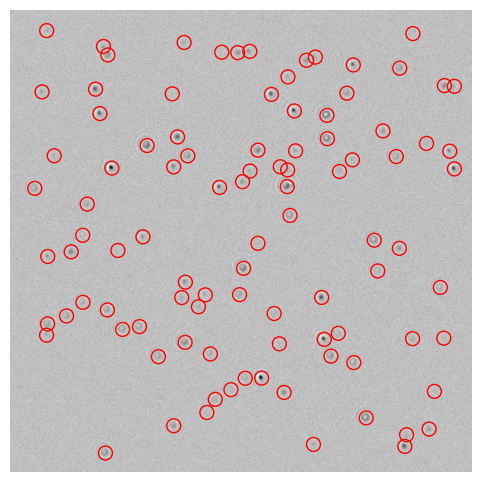

In [156]:
#Settings for LodeSTAR
alpha = 0.5
beta = 0.5
cutoff = 0.9825
mode = "quantile" #"constant"

plt.figure(figsize=(6, 6))
torch_image = torch.from_numpy(data).permute(2, 0, 1).unsqueeze(0).float()
detections = lodestar.detect(torch_image, alpha=alpha, beta=beta, 
                                mode=mode, cutoff=cutoff)[0]


plt.imshow(data[...,1], cmap="gray")
plt.scatter(detections[:,1], detections[:,0], s = 100, facecolors='none', edgecolors='r')
plt.axis("off")

plt.show()

In [157]:
# F1 score for LodeSTAR
F1_score_l = hp.get_F1_score(
    hp.add_bin_circles(detections, radius, mask)
    , GT_particles)
print(f"F1 score for LodeSTAR: {round(F1_score_l, 3)*100}%")

F1 score for LodeSTAR: 84.7%


## 3 - Quantification of particle properties in Quantitiative field imaging

xxx

In [158]:
# Padding size, 20 pixels gives a total size of 40x40 pixels.
padsize = 20

In [159]:
#Regions around the particles in the full frame.
rois = hp.get_rois(data, centroids, padsize)

In [160]:
# Calculate the polarizabilities for all the particles. Takes in the radius and refractive index.
polarizabilities_rois = hp.get_polarizability(labels[:,3]*1e6, labels[:,4])

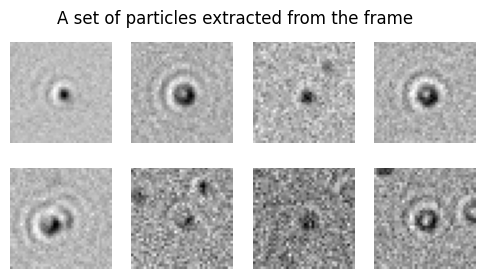

In [161]:
plt.figure(figsize=(6, 3))
plt.suptitle("A set of particles extracted from the frame")
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(rois[i,...,1], cmap="gray")
    plt.axis("off")

#### 3.2.1 Defining the optical system

xxx

In [162]:
IMAGE_SIZE = 40
NA = 1
MAGNIFICATION = 1
WAVELENGTH = 532e-9
RESOLUTION = 1.14e-7

In [163]:
optics = dt.Brightfield(
    NA=NA,
    magnification=MAGNIFICATION,
    wavelength=WAVELENGTH,
    resolution=RESOLUTION,
    return_field=True, 
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
)

#### 3.2.2 Defining the particle(s)

* We define spherical particles with radius ranging from 25nm up to 250nm and refractive index of 1.37 up to 1.6
* They are allowed to be slightly out of focus in a range of +-5 um. Pixel-range???

In [164]:
RADIUS_RANGE = (25e-9, 250e-9)
REFRACTIVE_INDEX_RANGE = (1.37, 1.6)

In [165]:
particle = dt.MieSphere(
    position=lambda: (IMAGE_SIZE / 2, IMAGE_SIZE / 2) + np.random.rand(2) * 4 - 2,
    z=lambda: np.random.randn() * 5,
    radius=lambda:np.random.uniform(*RADIUS_RANGE),
    refractive_index=lambda: np.random.uniform(*REFRACTIVE_INDEX_RANGE),
    L=8,
    position_unit="pixel",
    sigmaval=lambda radius: np.random.uniform()*(radius/1e-8)*2e-3,
)

#### 3.2.3 Create dataset of particles

The noise is simulated as gaussian distributed noise, with independent real and imaginary parts. Finally, the real and imaginary parts of the field are separated into two layers, and the plane wave is subtracted.

In [166]:
def func():
    def inner(image):
        image = image - 1
        output = np.zeros((*image.shape[:2], 2))
        output[..., 0:1] = np.real(image)
        output[..., 1:2] = np.imag(image)
        return output
    return inner

complex_to_float = dt.Lambda(func)


We now define how these objects combine. Note that the noise is added inside the optics. This means that it will have the same PSF as the sample, which is what is observed. 

In [167]:
dataset = optics(particle) >> dt.Gaussian(sigma=particle.sigmaval + 1j*particle.sigmaval) >> complex_to_float

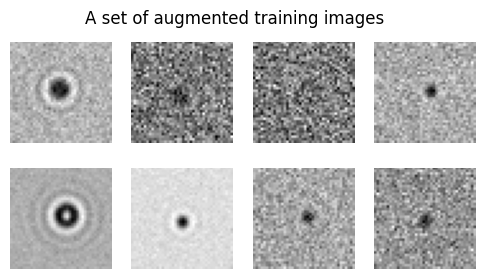

In [168]:
plt.figure(figsize=(6, 3))
plt.suptitle("A set of augmented training images")
for i in range(8):
    plt.subplot(2, 4, i+1)
    img = dataset.update().resolve()
    plt.imshow(img[...,1], cmap="gray")
    plt.axis("off")

#### 3.2.4 Defining the training label

We extract the parameters we want the network to learn.

In [169]:
MIN, MAX = hp.pol_range(RADIUS_RANGE, REFRACTIVE_INDEX_RANGE)
print(f"Min: {MIN}, Max: {MAX}")

Min: 1.958164848627912e-06, Max: 0.01273673470480586


In [170]:
def get_polarizability(radius, refractive_index, nm=1.333):
    # Get the polarizability
    pol = hp.get_polarizability(radius = radius*1e6, refractive_index = refractive_index, refractive_index_medium = nm)

    # Normalize the polarizability
    pol = pol / MAX

    return np.expand_dims(pol, -1)

#### 3.2.5 Defining quantification model (2DCNN)
xxx

In [171]:
conv = dl.ConvolutionalNeuralNetwork(
    in_channels = 2, 
    hidden_channels=[16, 32, 64], 
    out_channels = 64,
    pool = dl.torch.nn.MaxPool2d(kernel_size=2),
    out_activation=dl.torch.nn.LeakyReLU(0.1),
    )

mlp = dl.MultiLayerPerceptron(
    in_features = None, 
    hidden_features = [64, 32], 
    out_activation = dl.torch.nn.LeakyReLU(0.1), 
    out_features=1)

net = dl.Sequential(
    conv,
    mlp
)


In [172]:
regressor = dl.Regressor(
    model=net,
    loss=dl.torch.nn.MSELoss(),#dl.torch.nn.MSELoss(), dl.torch.nn.L1Loss()
    optimizer=dl.Adam(),
)
cnn_regressor = regressor.create()
cnn_regressor = cnn_regressor.to(DEV)

#### 3.2.6 Training of the model
xxx

In [173]:
#Pipeline for generating images and labels.
image_and_signal_pipeline = dataset & dataset >> dt.Value(get_polarizability, radius=particle.radius, refractive_index=particle.refractive_index)

In [174]:
#Training dataset
training_dataset = dt.pytorch.Dataset(image_and_signal_pipeline, length=10000, replace=False)
dataloader = dl.DataLoader(training_dataset, batch_size=32, shuffle=True)

#Validation dataset
val_dataset = dt.pytorch.Dataset(image_and_signal_pipeline, length=1000, replace=False)
val_dataloader = dl.DataLoader(val_dataset, batch_size=32, shuffle=True)

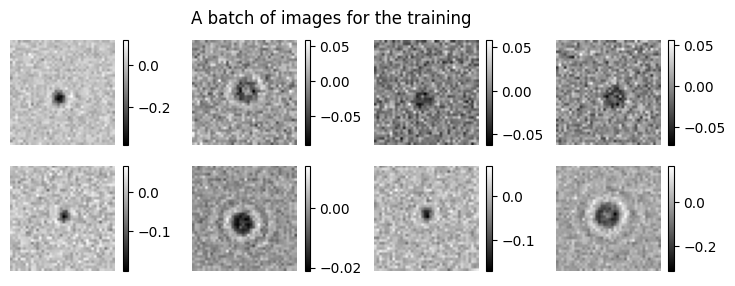

In [175]:
batch = next(iter(dataloader))

plt.figure(figsize=(9, 3))
plt.suptitle("A batch of images for the training")
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(batch[0][i,1], cmap="gray")
    plt.colorbar()
    plt.axis("off")

In [176]:
TRAIN_MODEL = False

if TRAIN_MODEL:
    #Train model for max_epochs.
    trainer = dl.Trainer(max_epochs=300)
    trainer.fit(cnn_regressor, dataloader, val_dataloader)
else:
    cnn_regressor.load_state_dict(torch.load("../models/brightfield/cnn_regressor.pth"))
    cnn_regressor.eval()
cnn_regressor = cnn_regressor.to(DEV)

#### 3.2.7 Validating the model on simulated data and ROIs from frame.
xxx


In [177]:
#Predict the signal
predictions = []
labels_ = []
for batch in val_dataloader:
    predictions.append(cnn_regressor(batch[0].to(DEV)))
    labels_.append(batch[1])

#Concatenate the predictions and labels
predictions = torch.concatenate(predictions)[:, 0].detach().cpu().numpy()
labels_ = torch.concatenate(labels_)[:, 0].detach().cpu().numpy()


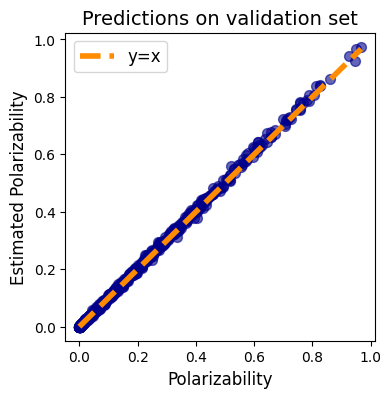

In [178]:
plt.figure(figsize=(4, 4))
plt.scatter(labels_, predictions, color="darkblue", alpha=0.6, s=50)
plt.plot([np.min(labels_), np.max(labels_)], [np.min(labels_), np.max(labels_)], color = 'darkorange', linestyle="--", linewidth=4, label="y=x")
plt.xlabel("Polarizability", fontsize=12)
plt.ylabel("Estimated Polarizability", fontsize=12)
plt.legend(fontsize=12)
plt.title("Predictions on validation set", fontsize=14)
plt.show()


In [179]:
#Predict on the rois
predictions_rois = [cnn_regressor(torch.from_numpy(roi).permute(2, 0, 1).unsqueeze(0).float().to(DEV)) for roi in rois]
predictions_rois = np.array([pred.detach().cpu().numpy()[0, 0] for pred in predictions_rois])

Text(0.5, 1.0, 'Predictions on ROIs')

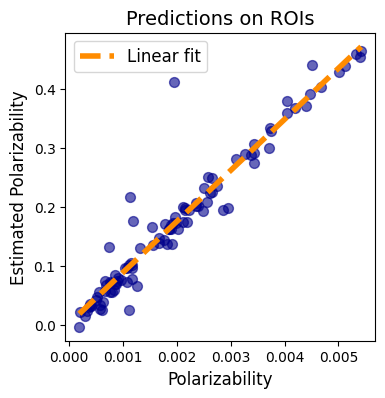

In [180]:
plt.figure(figsize=(4, 4))
plt.scatter(polarizabilities_rois, predictions_rois, color="darkblue", alpha=0.6, s=50)
#line fit
coefficients = np.polyfit(polarizabilities_rois, predictions_rois, 1)
polynomial = np.poly1d(coefficients)
x_axis = np.linspace(polarizabilities_rois.min(), polarizabilities_rois.max(), 100)
y_axis = polynomial(x_axis)
plt.plot(x_axis, y_axis, color = 'darkorange', linestyle="--", linewidth=4, label="Linear fit")
plt.xlabel("Polarizability", fontsize=12)
plt.ylabel("Estimated Polarizability", fontsize=12)
plt.legend(fontsize=12)
plt.title("Predictions on ROIs", fontsize=14)

### 3.4 Investigating the signal as dependence while keeping either refractive index or radius fixed.

#### 3.4.1 Fix refractive index 

In the quantitative field regime the polarizability should scale with $x^3$

In [181]:
FIX_RI = 1.4
RADIUS_RANGE = np.linspace(25e-9, 250e-9, 100)
samples_per_case = 10
radiuses = np.concatenate([np.repeat(x, samples_per_case) for x in RADIUS_RANGE])

In [182]:
DATA = []
for i, rad in enumerate(RADIUS_RANGE):
    if i % 10 == 0:
        print(f"Currently at {i}/{len(RADIUS_RANGE)}")

    #Get all the particles
    for _ in range(samples_per_case):
        im = dataset.update().resolve(refractive_index = FIX_RI, radius = rad)
        DATA.append(im)
DATA = np.array(DATA)

Currently at 0/100
Currently at 10/100
Currently at 20/100
Currently at 30/100
Currently at 40/100
Currently at 50/100
Currently at 60/100
Currently at 70/100
Currently at 80/100
Currently at 90/100


In [183]:
# Get the theoretical polarizabilities
theoretical_pol = hp.get_polarizability(radiuses*1e6, FIX_RI)

In [184]:
#Make prediction with the model.
pol_cnn_fix_ri = cnn_regressor(
    torch.from_numpy(DATA).permute(0, 3, 1, 2).float().to(DEV)
    ).cpu().detach().numpy()[:, 0]

In [185]:
#Normalize the signals
pol_cnn_fix_ri = pol_cnn_fix_ri / pol_cnn_fix_ri.mean()
theoretical_pol = theoretical_pol / theoretical_pol.mean()

Text(0.5, 1.0, 'Polarizability vs. Signal estimated with a 2DCNN')

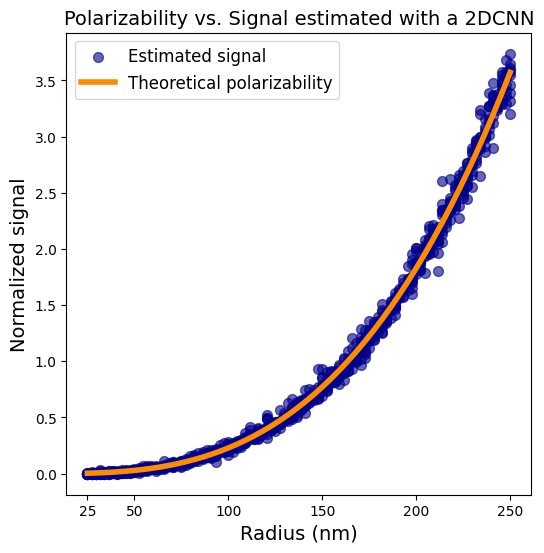

In [186]:
plt.figure(figsize=(6, 6))
plt.scatter(radiuses, pol_cnn_fix_ri, color="darkblue", alpha=0.6, s=50, label = 'Estimated signal')

#Line for theoretical
plt.plot(radiuses, theoretical_pol, linestyle="-", linewidth=4, label="Theoretical polarizability", color = 'darkorange')

plt.xticks([25e-9, 50e-9, 100e-9, 150e-9, 200e-9, 250e-9], ["25", "50", "100", "150", "200", "250"])
plt.xlabel("Radius (nm)", fontsize=14)
plt.ylabel("Normalized signal", fontsize=14)
plt.legend(fontsize=12)
plt.title("Polarizability vs. Signal estimated with a 2DCNN", fontsize=14)

#### 3.4.1 Fix radius 

In the quantitative field regime the polarizability should scale linearly when keeping the radius fixed.

In [187]:
FIX_RADIUS = 150e-9
RI_RANGE = np.linspace(1.37, 1.6, 100)
samples_per_case = 10
riis = np.concatenate([np.repeat(x, samples_per_case) for x in RI_RANGE])

In [188]:
DATA = []
for i, ri in enumerate(RI_RANGE):
    if i % 10 == 0:
        print(f"Currently at {i}/100")

    #Get all the particles
    for _ in range(samples_per_case):
        im = dataset.update().resolve(refractive_index = ri, radius = FIX_RADIUS)
        DATA.append(im)
DATA = np.array(DATA)


Currently at 0/100
Currently at 10/100
Currently at 20/100
Currently at 30/100
Currently at 40/100
Currently at 50/100
Currently at 60/100
Currently at 70/100
Currently at 80/100
Currently at 90/100


In [189]:
# Get the theoretical polarizabilities
theoretical_pol = hp.get_polarizability(FIX_RADIUS*1e6, riis)

In [190]:
#Predict with model
pol_cnn_fix_radius = cnn_regressor(
    torch.from_numpy(DATA).permute(0, 3, 1, 2).float().to(DEV)
    ).cpu().detach().numpy()[:, 0]

In [191]:
#Normalize the signals
pol_cnn_fix_radius = pol_cnn_fix_radius / pol_cnn_fix_radius.mean()
theoretical_pol = theoretical_pol / theoretical_pol.mean()

Text(0.5, 1.0, 'Polarizability vs. Signal estimated with a 2DCNN')

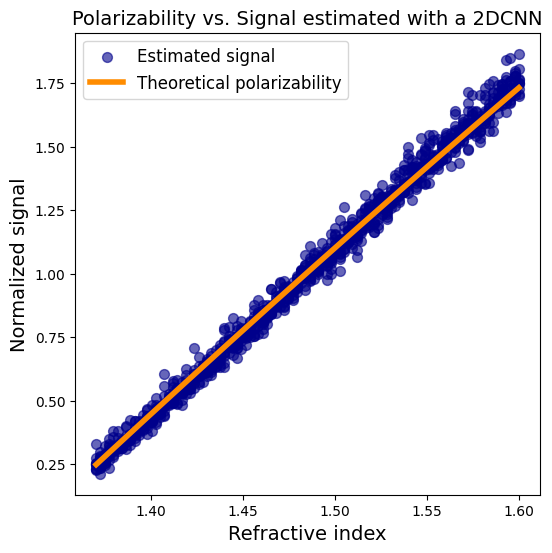

In [192]:
plt.figure(figsize=(6, 6))
plt.scatter(riis, pol_cnn_fix_radius, color="darkblue", alpha=0.6, s=50, label = 'Estimated signal')

#Line for theoretical
plt.plot(riis, theoretical_pol, linestyle="-", linewidth=4, label="Theoretical polarizability", color = 'darkorange')
plt.xlabel("Refractive index", fontsize=14)
plt.ylabel("Normalized signal", fontsize=14)
plt.legend(fontsize=12)
plt.title("Polarizability vs. Signal estimated with a 2DCNN", fontsize = 14)

## 4. Combining detection and quantification in Quantitative field imaging
xxx

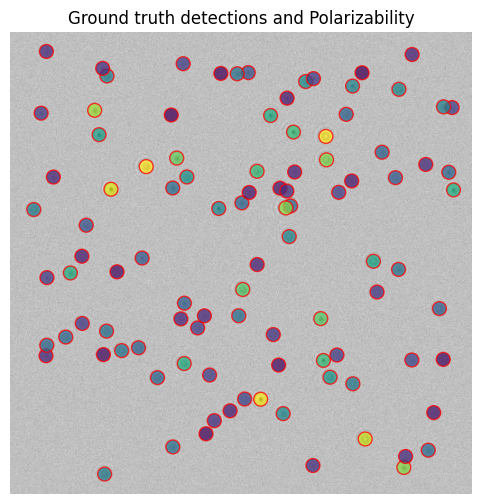

In [193]:
hp.plot_frame_with_detections_filled(
    data = data[...,1],
    positions = labels[:, :2],
    values = polarizabilities_rois,
    title = "Ground truth detections and Polarizability"
    )

### 4.1 LodeSTAR and 2DCNN for particle detection and quantification on a full frame
xxx

In [194]:
def LodeSTAR_2dcnn_full_frame_pipeline(data, lodestar, cnn_regressor, alpha = 0.5, beta = 0.5, cutoff = 0.95, padsize = 20):

    #Transform data to a Tensor
    torch_image = torch.from_numpy(data).permute(2, 0, 1).unsqueeze(0).float().to(DEV)

    #Detect particles with LodeSTAR
    detections = lodestar.detect(torch_image, alpha=alpha, beta=beta, 
                                    mode="quantile", cutoff=cutoff)[0]
    
    #If no detections, throw error.
    if len(detections) > 0:
        
        #Check so detections is not out of bounds
        detections = detections[(detections[:,0] > padsize) & (detections[:,0] < data.shape[0] - padsize) & 
                                (detections[:,1] > padsize) & (detections[:,1] < data.shape[1] - padsize)]

        #Get the signals
        signals = np.array([cnn_regressor(torch.from_numpy(roi).permute(2, 0, 1).unsqueeze(0).float().to(DEV)).cpu().detach().numpy()[0, 0]  
                            for roi in hp.get_rois(data, detections, padsize)])

        return detections, signals

    else:
        print("No detections")

In [195]:
detections, signals = LodeSTAR_2dcnn_full_frame_pipeline(data, lodestar, cnn_regressor, alpha = alpha, beta = beta, cutoff = cutoff, padsize = 20)

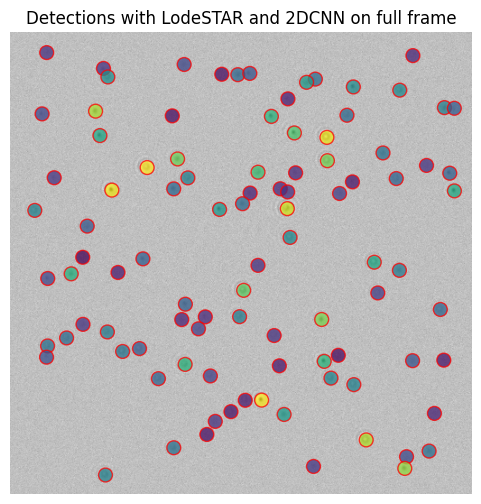

In [196]:
hp.plot_frame_with_detections_filled(
    data = data[...,1],
    positions = detections,
    values = signals,
    title = "Detections with LodeSTAR and 2DCNN on full frame"
    )